In [1]:
# Data Preprocessing
import numpy as np
from six.moves import cPickle

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Neural network
import tensorflow as tf
tf.InteractiveSession()

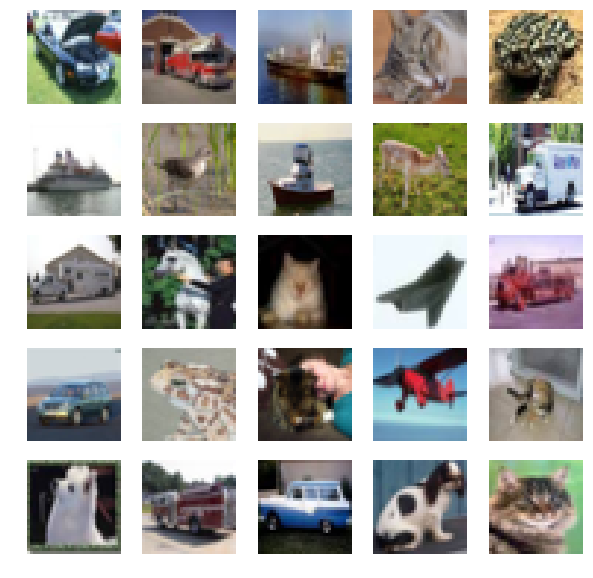

In [2]:
# data loading into python dictionary
f = open('cifar-10-batches-py/data_batch_1', 'rb')      
datadict = cPickle.load(f,encoding='latin1')
f.close()

X = datadict['data']       # image vectors
Y = datadict['labels']     # label value

# we reshape the image in 3x32x32
# x and y axis are swaped so we use transpose to correct the axis
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('uint8')   # shape of X = [10000,32,32,3]

Y = np.array(Y)

# showing images
fig, axis1 = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        k = np.random.choice(range(len(X)))
        axis1[i][j].set_axis_off()               # trun off values of axis and remove black border
        axis1[i][j].imshow(X[k:k+1][0])
        

In [3]:
height = 32            # height of image
width = 32             # width of image 
num_classes = 10       # number of classes
dropout = 0.7 
learning_rate = .001

# one hot encoding of labels
label = (tf.contrib.layers.one_hot_encoding(labels=Y,num_classes=num_classes)).eval()  

# Define Placeholders
x_image = tf.placeholder(tf.float32, [None, height, width, 3], name="X_image")
y_image = tf.placeholder(tf.float32, [None, num_classes], name="Y_image")
keep_prob = tf.placeholder(tf.float32, name="Dropout")

In [4]:
def alexnet(x, weights, biases, dropout=1.0):
    '''
    Full (simplified) AlexNet architecture:
    [227x227x3] INPUT
    [55x55x96] CONV1: 96 11x11 filters at stride 4, pad 0
    [27x27x96] MAX POOL1: 3x3 filters at stride 2
    [27x27x96] NORM1: Normalization layer
    [27x27x256] CONV2: 256 5x5 filters at stride 1, pad 2
    [13x13x256] MAX POOL2: 3x3 filters at stride 2
    [13x13x256] NORM2: Normalization layer
    [13x13x384] CONV3: 384 3x3 filters at stride 1, pad 1
    [13x13x384] CONV4: 384 3x3 filters at stride 1, pad 1
    [13x13x256] CONV5: 256 3x3 filters at stride 1, pad 1
    [6x6x256] MAX POOL3: 3x3 filters at stride 2
    [4096] FC6: 4096 neurons
    [4096] FC7: 4096 neurons
    [1000] FC8: 1000 neurons (class scores)
    '''
    #layer1                     (instead of strides=[1,4,4,1])                                                      size
    conv_1 = tf.nn.conv2d(x, weights['w1'], strides=[1,1,1,1], padding='SAME') + biases['b1']                   # 32*32*96 
    relu_1 = tf.nn.relu(conv_1)                                                                                 # 32*32*96
    maxpool_1 = tf.nn.max_pool(relu_1, strides=[1,2,2,1], ksize=[1,3,3,1], padding='SAME')                      # 16*16*96  
    norm_1 = tf.nn.local_response_normalization(maxpool_1, depth_radius=4, bias=1.0, alpha=12e-05, beta=0.75)   # 16*16*96
    
    #layer2
    conv_2 = tf.nn.conv2d(norm_1, weights['w2'], strides=[1,1,1,1], padding='SAME') + biases['b2']              # 16*16*256
    relu_2 = tf.nn.relu(conv_2)                                                                                 # 16*16*256  
    maxpool_2 = tf.nn.max_pool(relu_2, strides=[1,2,2,1], ksize=[1,3,3,1], padding='SAME')                      # 8*8*256 
    norm_2 = tf.nn.local_response_normalization(maxpool_2, depth_radius=4, bias=1.0, alpha=12e-05, beta=0.75)   # 8*8*256   
    
    #layer3
    conv_3 = tf.nn.conv2d(norm_2, weights['w3'], strides=[1,1,1,1], padding='SAME') + biases['b3']              # 8*8*384 
    relu_3 = tf.nn.relu(conv_3)                                                                                 # 8*8*384 
            
    #layer4
    conv_4 = tf.nn.conv2d(relu_3, weights['w4'], strides=[1,1,1,1], padding='SAME') + biases['b4']              # 8*8*384 
    relu_4 = tf.nn.relu(conv_4)                                                                                 # 8*8*384
        
    #layer5
    conv_5 = tf.nn.conv2d(relu_4, weights['w5'], strides=[1,1,1,1], padding='SAME') + biases['b5']              # 8*8*256   
    relu_5 = tf.nn.relu(conv_5)                                                                                 # 8*8*256    
    maxpool_5 = tf.nn.max_pool(relu_5, strides=[1,2,2,1], ksize=[1,3,3,1], padding='SAME')                      # 4*4*256   
    
    #layer6
    reshape_1 = tf.reshape(maxpool_5, [-1, int(np.prod(maxpool_5.get_shape()[1:]))])                            # -1, 4096 
    
    fc_1 = tf.matmul(reshape_1, weights['w6']) + biases['b6']                                                   # 1024 (instead of 4096)
    relu_fc_1 = tf.nn.relu(fc_1)
      
    #layer7
    fc_2 = tf.matmul(relu_fc_1, weights['w7']) + biases['b7']                                               #1024 (instead of 4096) 
    relu_fc_2 = tf.nn.relu(fc_2)
    
    #output layer
    output = tf.matmul(relu_fc_2, weights['out']) + biases['out']                                              #10 

    return output

In [5]:
weights = {
        'w1' : tf.Variable(tf.random_normal([11,11,3,96])),
        'w2' : tf.Variable(tf.random_normal([5,5,96,256])),
        'w3' : tf.Variable(tf.random_normal([3,3,256,384])),
        'w4' : tf.Variable(tf.random_normal([3,3,384,384])),
        'w5' : tf.Variable(tf.random_normal([3,3,384,256])),
        'w6' : tf.Variable(tf.random_normal([4*4*256,1024])),
        'w7' : tf.Variable(tf.random_normal([1024,1024])),
        'out' : tf.Variable(tf.random_normal([1024,10]))
        }

biases = {
        'b1' : tf.Variable(tf.random_normal([96])),
        'b2' : tf.Variable(tf.random_normal([256])),
        'b3' : tf.Variable(tf.random_normal([384])),
        'b4' : tf.Variable(tf.random_normal([384])),
        'b5' : tf.Variable(tf.random_normal([256])),
        'b6' : tf.Variable(tf.random_normal([1024])),
        'b7' : tf.Variable(tf.random_normal([1024])),
        'out' : tf.Variable(tf.random_normal([10]))
        }

print("weights ready")

weights ready


In [6]:

pred = alexnet(x_image, weights, biases, keep_prob)

with tf.name_scope("Cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_image, logits=pred))
    tf.summary.scalar("cross_entropy", cross_entropy)
    
with tf.name_scope("Train_step"):    
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope("Accuracy"):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_image, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)
    
print('Network ready')

Network ready


In [7]:
train_batch_size = 128

def random_batch():
    # Number of images in the training-set.
    num_images = len(X)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = X[idx, :, :, :]
    y_batch = label[idx, :]

    return x_batch, y_batch

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(20000):
       
    x_data,y_label = random_batch()
    if i % 1 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x_image: x_data, y_image: y_label, keep_prob: 1})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    
    sess.run(train_step, feed_dict={x_image: x_data, y_image: y_label, keep_prob: dropout})
    
sess.close()

step 0, training accuracy 0.125
step 1, training accuracy 0.0703125
